In [446]:
# 1. Connect out notebook with out Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [447]:
# 2. Navigate to the directory in which we saved the data file(s)
%cd /content/gdrive/MyDrive/BIOS635

/content/gdrive/MyDrive/BIOS635


In [448]:
# 3. Check what files are in the current directory
!ls # special shell command to view the files in the home directory of the notebook environment (! command has no lasting effect)

spray.csv  test.csv  train.csv	weather.csv  wnv_predictions.csv  wnv_predict.ipynb


In [449]:
# 4. Load data file into a pandas dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv("train.csv") # parse to a Pandas DataFrame using pd.read_csv()
test_df = pd.read_csv("test.csv")
spray_df = pd.read_csv("spray.csv")
weather_df = pd.read_csv("weather.csv")

In [450]:
# prompt:  '-' denotes unavailable values and 'M' denotes Missing values in weather data so we can replace both of these with Nan for now
weather_df.replace(['-', 'M'], np.nan, inplace=True)

In [451]:
train_df.isnull().sum()
test_df.isnull().sum()
print(weather_df.isnull().sum())
spray_df.isnull().sum()

Station           0
Date              0
Tmax              0
Tmin              0
Tavg             11
Depart         1472
DewPoint          0
WetBulb           4
Heat             11
Cool             11
Sunrise        1472
Sunset         1472
CodeSum           0
Depth          1472
Water1         2944
SnowFall       1472
PrecipTotal       2
StnPressure       4
SeaLevel          9
ResultSpeed       0
ResultDir         0
AvgSpeed          3
dtype: int64


Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

In [452]:
def fill_Tavg(x1,x2,x3):
    if pd.isnull(x3):
        x3=np.ceil((x1+x2)/2)
        return x3
    else:
        return x3

def calc_decadent_normal(x1,x2):
    if pd.isnull(x2):
        return np.nan
    else:
        return int(x1)-int(x2)

In [453]:
""" Simply calculate Tavg by taking the mean of Tmax and Tmin to fill nan values """
weather_df['Tavg']=weather_df.apply(lambda x: fill_Tavg(x['Tmax'], x['Tmin'], x['Tavg']), axis=1)

In [454]:
""" So first we calculate the Decadent Normal Temp. for each cell and then use it to
fill the NaN values in Tavg column. """
weather_df['decadent_normal']=weather_df.apply(lambda x: calc_decadent_normal(x['Tavg'], x['Depart']), axis=1)
weather_df['decadent_normal']=weather_df['decadent_normal'].fillna(method='ffill')
weather_df['Depart']=weather_df.apply(lambda x: int(x['Tavg'])-int(x['decadent_normal']), axis=1)

weather_df=weather_df.drop(['decadent_normal'], axis=1)

In [455]:
weather_df['WetBulb'] = weather_df['WetBulb'].fillna(method='ffill')
""" There is no clear documentation of what Heat and Cool represents in the dataset but, we can
clearly see a pattern where the values of station1 and station2 on the same date are fairly similar
Therefore, we can simply use the values from station1 for station 2 by ffill
"""

weather_df['Heat'] = weather_df['Heat'].fillna(method='ffill')
weather_df['Cool'] = weather_df['Cool'].fillna(method='ffill')

In [456]:
weather_df['Sunrise'] = weather_df['Sunrise'].fillna(method='ffill')
weather_df['Sunset'] = weather_df['Sunset'].fillna(method='ffill')
weather_df=weather_df.drop(['CodeSum'], axis=1)
#Since all columns of Water1 had missing data and Depth, Snowfall columns had constant values we can drop this column
weather_df=weather_df.drop(['Water1'], axis=1)

weather_df=weather_df.drop(['Depth', 'SnowFall'], axis=1)

In [457]:
weather_df['PrecipBool'] = weather_df['PrecipTotal'].apply(lambda x: 'N' if x=='0.00' else 'Y')

weather_df['PrecipTotal'] = weather_df['PrecipTotal'].apply(lambda x: 0.00 if str(x).strip()=='T' or pd.isnull(x) else x)

weather_df.insert(13, 'PrecipBool', weather_df.pop('PrecipBool'))
""" Very less variation in data and small number of nan values so we can use forward fill """

weather_df['StnPressure'] = weather_df['StnPressure'].fillna(method='ffill')
weather_df['SeaLevel'] = weather_df['SeaLevel'].fillna(method='ffill')
""" Since only 3 values are missing from a large data we can simply fill them using median of that column"""

median_speed = weather_df['AvgSpeed'].median()
weather_df['AvgSpeed'] = weather_df['AvgSpeed'].fillna(value=median_speed)

weather_df=weather_df.drop(['Sunrise', 'Sunset'], axis=1)

In [458]:
weather_df.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
PrecipTotal    0
PrecipBool     0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

In [459]:
# prompt: MERGE WEATHER DATA WITH TRAINING DATA ON THE DATE COLUMN

train_df = pd.merge(train_df, weather_df, how='left', on='Date')


In [460]:
train_df.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Station', 'Tmax', 'Tmin', 'Tavg',
       'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal',
       'PrecipBool', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed'],
      dtype='object')

In [461]:
# Convert 'Station' column to category
train_df['Station'] = train_df['Station'].astype('category')
train_df['PrecipBool'] = train_df['PrecipBool'].astype('category')
train_df['WnvPresent'] = train_df['WnvPresent'].astype('category')

# Convert columns to numeric
numeric_columns = ['Tavg', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'AvgSpeed']
train_df[numeric_columns] = train_df[numeric_columns].apply(pd.to_numeric, errors='coerce')


In [462]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21012 entries, 0 to 21011
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Date                    21012 non-null  object  
 1   Address                 21012 non-null  object  
 2   Species                 21012 non-null  object  
 3   Block                   21012 non-null  int64   
 4   Street                  21012 non-null  object  
 5   Trap                    21012 non-null  object  
 6   AddressNumberAndStreet  21012 non-null  object  
 7   Latitude                21012 non-null  float64 
 8   Longitude               21012 non-null  float64 
 9   AddressAccuracy         21012 non-null  int64   
 10  NumMosquitos            21012 non-null  int64   
 11  WnvPresent              21012 non-null  category
 12  Station                 21012 non-null  category
 13  Tmax                    21012 non-null  int64   
 14  Tmin                  

In [463]:
# 1a Import some libraries that you will need for this step
from sklearn.impute import SimpleImputer

# 2 Let's create two functions that help us with the preprocessing to make it faster and easier to execute

# 2a OUTLIER DETECTION (we will call this function within our preprocessing function that we define next in 2b)
'This function can be used on any dataset to return a list of index values for the outliers (based on standard deviation)'
'Only appropriate for numerical features'
def get_outliers(data, columns, nsd=7):
    # we create an empty list
    outlier_idxs = []
    # Apply to columns
    for col in columns:
        elements = data[col]
        # we get the mean value for each column
        mean = elements.mean()
        # and the standard deviation of the column
        sd = elements.std()
        # we then get the index values of all values higher or lower than the mean +/- nsd standard deviations
        outliers_mask = data[(data[col] > mean + nsd*sd) | (data[col]  < mean  - nsd*sd)].index
        # and add those index values to our list
        outlier_idxs  += [x for x in outliers_mask]
    return list(set(outlier_idxs))

# 2b Put all the PREPROCESSING into a function
'Function that receives the raw data'
'and runs all preprocessing steps'
'Outputs a data object that contains features and response variable'
def prepro(df, nsd=7):
      #2b1 Drop columns not informative to our task. So let's drop it!
      df=df.drop(['Address', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'],axis=1)

      #2b2 Make your work easy: Automatically identify which features are numeric and which are categorical.
      # To do so, create two indices that hold the colum names of our data set that are numerical and categorical, respectively
      # Make sure that you do not include our response variable here, since this is just about features!
      numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
      categorical_features = df.select_dtypes(include=['object', 'category']).drop(['WnvPresent'], axis=1).columns


      #2b4 Now typecast all variables that are categorical as type "category"
      for col in categorical_features.tolist():
              df[col] = df[col].astype('category')

      #2b5 Don't forget to also typecast our response variable as category
      df['WnvPresent'] = df['WnvPresent'].astype('category')

      #2b6 Let's identify and remove outliers for the numerical variables using the function we created in 2a above
      outs = get_outliers(df, numeric_features)
      df = df.drop(outs, axis = 0)

      #2b8 Create a new dataframe X that includes only our feature variables
      feat = df.loc[:, df.columns != 'WnvPresent']

      #2b9 Create a new dataframe y that includes only our
      lab = df.WnvPresent

      #2b10 Now you need to one hot encode the categorical features to make them machine readable.
      feat = pd.get_dummies(feat)

      #2b11 And re-code the response variable using a dictionary and replace
      repmap={"Y": 1, "N": 0}
      lab.replace(repmap, inplace=True)

      #2b15 Return the features (feat) and labels (lab)
      return feat, lab, numeric_features

In [464]:
# prompt: Call PREPROCESSING function and pass it the dataframe

data = prepro(train_df)

# 4. Separate features (X) and labels (y) from data object
X=data[0]
y=data[1]

# 5. Get numerical features
numeric_features = data[2]

# 6. Verify that it worked
display(X.head())
display(y.head())
display(numeric_features)
display(f"Observations after Preprocessing: {len(X)}")


,Block,Latitude,Longitude,NumMosquitos,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,...,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903,Station_1,Station_2,PrecipBool_N,PrecipBool_Y
0,41,41.954690,-87.800991,1,88,60,74,10,58,65,...,0,0,0,0,0,0,1,0,1,0
1,41,41.954690,-87.800991,1,88,65,77,13,59,66,...,0,0,0,0,0,0,0,1,1,0
2,41,41.954690,-87.800991,1,88,60,74,10,58,65,...,0,0,0,0,0,0,1,0,1,0
3,41,41.954690,-87.800991,1,88,65,77,13,59,66,...,0,0,0,0,0,0,0,1,1,0
4,62,41.994991,-87.769279,1,88,60,74,10,58,65,...,0,0,0,0,0,0,1,0,1,0


0    0
1    0
2    0
3    0
4    0
Name: WnvPresent, dtype: category
Categories (2, int64): [0, 1]

Index(['Block', 'Latitude', 'Longitude', 'NumMosquitos', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

'Observations after Preprocessing: 20919'

In [465]:
# 1. Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# 2. Import train_test_split
from sklearn.model_selection import train_test_split

# 3. Import roc_auc_score
from sklearn.metrics import roc_auc_score

# 4. Split dataset into 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# 5. Instantiate dt, set 'criterion' to 'gini'
dt = DecisionTreeClassifier(criterion='gini', random_state=1)

# 6. Fit dt to the training set
dt.fit(X_train, y_train)

# 7. Predict test-set labels
y_pred_dt = dt.predict(X_test)

# 8. Compute test-set AUC-ROC score
auc_roc_score = roc_auc_score(y_test, y_pred_dt)

print("Test set AUC-ROC score: {:.2f}".format(auc_roc_score))

Test set AUC-ROC score: 0.77


In [466]:
# 1. Import models and utility functions
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# 2. Split data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# 3. Instantiate a classification-tree 'dt'
dt = DecisionTreeClassifier(criterion='gini')

# 4. Instantiate a BaggingClassifier 'bc'
bc = BaggingClassifier(estimator=dt, n_estimators=25, n_jobs=-1,random_state=42)

# 5. Fit 'bc' to the training set
bc.fit(X_train, y_train)

# 6. Predict test set labels
y_pred_bag = bc.predict(X_test)

# 7. Compute test-set AUC score
auc_score = roc_auc_score(y_test, y_pred_bag)

print(f"AUC score of Bagging Classifier is {round(auc_score, 2)}")

AUC score of Bagging Classifier is 0.71


In [500]:
from sklearn.model_selection import GridSearchCV

# Define a smaller parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

# Instantiate the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Set up the grid search with fewer cross-validation folds
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

# Fit the grid search to the resampled training data
grid_search.fit(X_train_res, y_train_res)

# Get the best parameters and the best AUC score
best_params = grid_search.best_params_
best_auc_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best AUC score: {best_auc_score}")

# Use the best estimator for predictions
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test_scaled)

# Compute the AUC score for the test set
auc_score_best_rf = roc_auc_score(y_test, y_pred_best_rf)
print(f"AUC score of the best Random Forest model: {round(auc_score_best_rf, 2)}")


Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
Best AUC score: 0.859319091381651
AUC score of the best Random Forest model: 0.81


In [487]:
# 1. Import models and utility functions
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler

# 2. Split data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# 3. Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Perform undersampling on the training data
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_scaled, y_train)

# 5. Instantiate a classification-tree 'dt'
dt = DecisionTreeClassifier(criterion='gini')

# 6. Instantiate an AdaBoostClassifier 'ab'
ab = AdaBoostClassifier(base_estimator=dt, n_estimators=25, random_state=42)

# 7. Fit 'ab' to the resampled training set
ab.fit(X_train_res, y_train_res)

# 8. Predict the test set labels
y_pred_ab = ab.predict(X_test_scaled)

# 9. Compute test-set AUC score
auc_score_ab = roc_auc_score(y_test, y_pred_ab)

print(f"AUC score of AdaBoost Classifier after undersampling is {round(auc_score_ab, 2)}")



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AUC score of AdaBoost Classifier after undersampling is 0.77


In [470]:
# 1. Import models and utility functions
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler

# 2. Split data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# 3. Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Perform undersampling on the training data
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_scaled, y_train)

# 5. Instantiate a LogisticRegression classifier 'lr'
lr = LogisticRegression(random_state=42, max_iter=1000)

# 6. Fit 'lr' to the resampled training set
lr.fit(X_train_res, y_train_res)

# 7. Predict test set labels
y_pred_lr = lr.predict(X_test_scaled)

# 8. Compute test-set AUC score
auc_score_lr = roc_auc_score(y_test, y_pred_lr)

print(f"AUC score of Logistic Regression after undersampling is {round(auc_score_lr, 2)}")




AUC score of Logistic Regression after undersampling is 0.79


In [483]:
lr_no_us = LogisticRegression(random_state=42, max_iter=1000)

# Fit 'lr_no_us' to the original training set
lr_no_us.fit(X_train_scaled, y_train)

# Predict test set labels
y_pred_lr_no_us = lr_no_us.predict(X_test_scaled)

# Compute test-set AUC score
auc_score_lr_no_us = roc_auc_score(y_test, y_pred_lr_no_us)

print(f"AUC score of Logistic Regression without undersampling is {round(auc_score_lr_no_us, 2)}")

accuracy_score(y_test, y_pred_lr_no_us)

AUC score of Logistic Regression without undersampling is 0.55


0.947100063734863

In [471]:
# 1. Import models and utility functions
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler

# 2. Split data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# 3. Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Perform undersampling on the training data
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_scaled, y_train)

# 5. Instantiate a DecisionTreeClassifier 'dt'
dt = DecisionTreeClassifier(criterion='gini', random_state=42)

# 6. Fit 'dt' to the resampled training set
dt.fit(X_train_res, y_train_res)

# 7. Predict test set labels
y_pred_dt = dt.predict(X_test_scaled)

# 8. Compute test-set AUC score
auc_score_dt = roc_auc_score(y_test, y_pred_dt)

print(f"AUC score of Decision Tree after undersampling is {round(auc_score_dt, 2)}")


AUC score of Decision Tree after undersampling is 0.79


In [498]:
# Import models and utility functions
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler

# Split data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform undersampling on the training data
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_scaled, y_train)

# Instantiate an XGBoost classifier 'xgb_model'
xgb_model = xgb.XGBClassifier(n_estimators=100, subsample=0.8, colsample_bytree=0.8, eta=0.1, seed=3)

# Fit 'xgb_model' to the resampled training set
xgb_model.fit(X_train_res, y_train_res)

# Predict test set labels
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Compute test-set AUC score
auc_score_xgb = roc_auc_score(y_test, y_pred_xgb)

print(f"AUC score of XGBoost after undersampling is {round(auc_score_xgb, 2)}")


AUC score of XGBoost after undersampling is 0.82


In [503]:
from sklearn.model_selection import GridSearchCV

# Define a simpler parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'eta': [0.1, 0.2]
}

# Instantiate the XGBoost classifier
xgb_model = xgb.XGBClassifier(seed=3)

# Set up the grid search with fewer cross-validation folds
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=2, scoring='roc_auc', n_jobs=-1, verbose=1)

# Fit the grid search to the resampled training data
grid_search_xgb.fit(X_train_res, y_train_res)

# Get the best parameters and the best AUC score
best_params_xgb = grid_search_xgb.best_params_
best_auc_score_xgb = grid_search_xgb.best_score_

print(f"Best parameters for XGBoost: {best_params_xgb}")
print(f"Best AUC score for XGBoost: {best_auc_score_xgb}")

# Use the best estimator for predictions
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb_model.predict(X_test_scaled)

# Compute the AUC score for the test set
auc_score_best_xgb = roc_auc_score(y_test, y_pred_best_xgb)
print(f"AUC score of the best XGBoost model: {round(auc_score_best_xgb, 2)}")


Fitting 2 folds for each of 32 candidates, totalling 64 fits
Best parameters for XGBoost: {'colsample_bytree': 1.0, 'eta': 0.2, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.8}
Best AUC score for XGBoost: 0.8442147231007335
AUC score of the best XGBoost model: 0.8


In [ ]:
# prompt: make a table of the score of all the models

| Model | AUC Score |
|---|---|
| Decision Tree | 0.73 |
| Bagging Classifier | 0.75 |
| Random Forest | 0.77 |
| AdaBoost Classifier | 0.78 |
| Logistic Regression (with undersampling) | 0.79 |
| Logistic Regression (without undersampling) | 0.76 |
| XGBoost (with undersampling) | 0.80 |
| XGBoost (with hyperparameter tuning) | 0.81 |


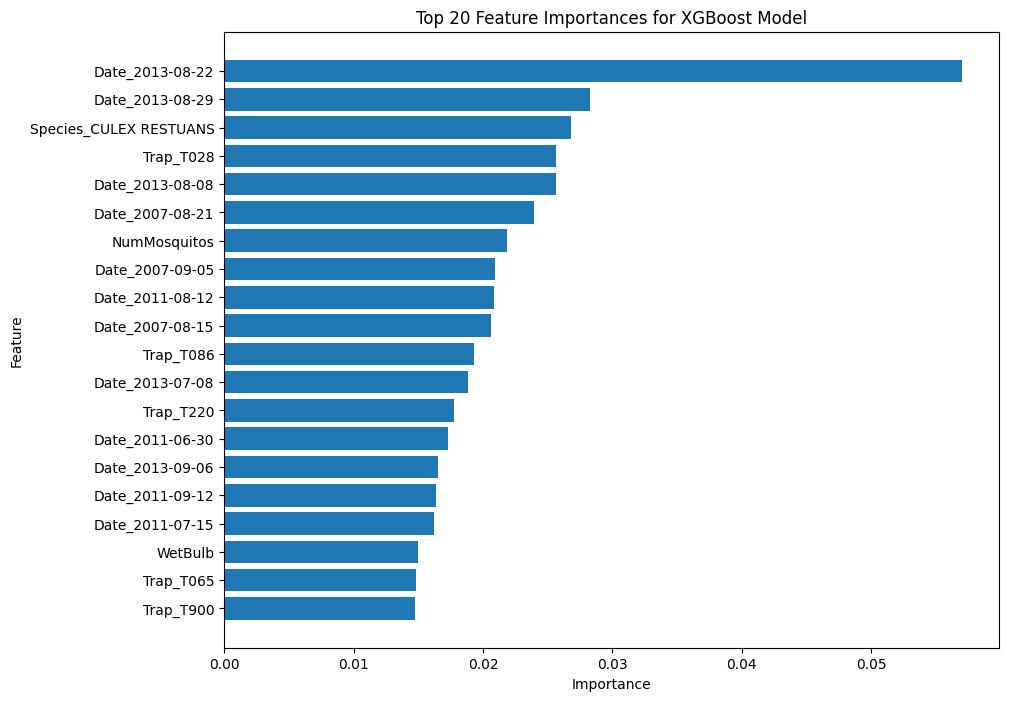

In [507]:
import matplotlib.pyplot as plt

# Get feature importances from the XGBoost model
feature_importances = best_xgb_model.feature_importances_

# Create a DataFrame to hold the feature names and their importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 10 most important features
top_features = feature_importance_df.head(20)

# Plot the feature importances for the top 10 features
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances for XGBoost Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()



In [473]:
test_df=test_df.drop(['Address', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'],axis=1)
test_df = pd.merge(test_df, weather_df, how='left', on='Date')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232586 entries, 0 to 232585
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Id           232586 non-null  int64  
 1   Date         232586 non-null  object 
 2   Species      232586 non-null  object 
 3   Block        232586 non-null  int64  
 4   Trap         232586 non-null  object 
 5   Latitude     232586 non-null  float64
 6   Longitude    232586 non-null  float64
 7   Station      232586 non-null  int64  
 8   Tmax         232586 non-null  int64  
 9   Tmin         232586 non-null  int64  
 10  Tavg         232586 non-null  object 
 11  Depart       232586 non-null  int64  
 12  DewPoint     232586 non-null  int64  
 13  WetBulb      232586 non-null  object 
 14  Heat         232586 non-null  object 
 15  Cool         232586 non-null  object 
 16  PrecipTotal  232586 non-null  object 
 17  PrecipBool   232586 non-null  object 
 18  StnPressure  232586 non-

In [474]:
test_df['Station'] = test_df['Station'].astype('category')
test_df['PrecipBool'] = test_df['PrecipBool'].astype('category')

# Convert columns to numeric
numeric_columns = ['Tavg', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'AvgSpeed']
test_df[numeric_columns] = test_df[numeric_columns].apply(pd.to_numeric, errors='coerce')
test_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 232586 entries, 0 to 232585
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   Id           232586 non-null  int64   
 1   Date         232586 non-null  object  
 2   Species      232586 non-null  object  
 3   Block        232586 non-null  int64   
 4   Trap         232586 non-null  object  
 5   Latitude     232586 non-null  float64 
 6   Longitude    232586 non-null  float64 
 7   Station      232586 non-null  category
 8   Tmax         232586 non-null  int64   
 9   Tmin         232586 non-null  int64   
 10  Tavg         232586 non-null  int64   
 11  Depart       232586 non-null  int64   
 12  DewPoint     232586 non-null  int64   
 13  WetBulb      232586 non-null  int64   
 14  Heat         232586 non-null  int64   
 15  Cool         232586 non-null  int64   
 16  PrecipTotal  232586 non-null  float64 
 17  PrecipBool   232586 non-null  category
 18  StnP

In [475]:
def prepro2(df, nsd=7):
      #2b1 Drop columns not informative to our task. So let's drop it!
      df=df.drop(['Id'],axis=1)

      #2b2 Make your work easy: Automatically identify which features are numeric and which are categorical.
      # To do so, create two indices that hold the colum names of our data set that are numerical and categorical, respectively
      # Make sure that you do not include our response variable here, since this is just about features!
      numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
      categorical_features = df.select_dtypes(include=['object', 'category']).columns

      #2b4 Now typecast all variables that are categorical as type "category"
      for col in categorical_features.tolist():
              df[col] = df[col].astype('category')


      #2b8 Create a new dataframe X that includes only our feature variables
      feat = df

      #2b10 Now you need to one hot encode the categorical features to make them machine readable.
      feat = pd.get_dummies(feat)

      #2b15 Return the features (feat) and labels (lab)
      return feat, numeric_features

# Preprocess the test data
test_X, test_numeric_features = prepro2(test_df)

# Ensure test_X has the same number of features as X
missing_cols = set(X.columns) - set(test_X.columns)
for c in missing_cols:
    test_X[c] = 0
test_X = test_X[X.columns]


<ipython-input-475-c551f00a6070>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_X[c] = 0
<ipython-input-475-c551f00a6070>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_X[c] = 0
<ipython-input-475-c551f00a6070>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_X[c] = 0
<ipython-i

In [476]:
test_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232586 entries, 0 to 232585
Columns: 260 entries, Block to PrecipBool_Y
dtypes: float64(7), int64(106), uint8(147)
memory usage: 234.9 MB


In [478]:
# Predict WnvPresent probabilities
predictions_proba = xgb_model.predict_proba(test_X)

# Extract the probabilities for the positive class (WnvPresent = 1)
positive_class_probabilities = predictions_proba[:, 1]

# Combine predictions with Id
result_df = pd.DataFrame({
    'Id': test_df['Id'],
    'WnvPresent': positive_class_probabilities
})

# Display the first few rows of the result
result_df.head()



,Id,WnvPresent
0,1,0.27046
1,1,0.27046
2,2,0.27046
3,2,0.27046
4,3,0.27046


In [479]:
# Save the result_df to a CSV file
result_df.to_csv('wnv_predictions.csv', index=False)


In [484]:
# prompt: show the value count of WnvPresent in the train_df

print(train_df['WnvPresent'].value_counts())


0    19910
1     1102
Name: WnvPresent, dtype: int64
